## Imports

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

## Read Data

In [2]:
data_X = pd.read_csv("data/medical/historical_X.dat", delim_whitespace=True, header=None, dtype='bool')
data_X.info()
data_X.isna().sum().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 130 entries, 0 to 129
dtypes: bool(130)
memory usage: 1.2 MB


0

In [3]:
data_a = pd.read_csv("data/medical/historical_A.dat", delim_whitespace=True, header=None, dtype='bool')
data_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       10000 non-null  bool 
dtypes: bool(1)
memory usage: 9.9 KB


In [4]:
data_y = pd.read_csv("data/medical/historical_Y.dat", delim_whitespace=True, header=None, dtype='bool')
data_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       10000 non-null  bool 
dtypes: bool(1)
memory usage: 9.9 KB


## Modeling

In [5]:
X = tf.convert_to_tensor(data_X.values, dtype=tf.float32)
a = tf.convert_to_tensor(data_a.values, dtype=tf.float32)
y = tf.convert_to_tensor(data_y.values, dtype=tf.float32)

In [6]:
def gen_logistic_model(X, a, prior_mean=0, prior_scale=1):
    num_of_features = data_X.shape[1]
    mean = tf.cast(prior_mean, tf.float32)
    scale = tf.cast(prior_scale, tf.float32)

    return tfd.JointDistributionSequential([
        tfd.Sample(tfd.Normal(loc=mean, scale=scale), sample_shape=[1, 1], name='alpha_1'),
        tfd.Sample(tfd.Normal(loc=mean, scale=scale), sample_shape=[1, 1], name='alpha_2'),
        tfd.Independent(
            tfd.Normal(
                loc=tf.zeros([num_of_features, 1]) + mean,
                scale=tf.ones([num_of_features, 1]) * scale,
                name='beta_1'),
            reinterpreted_batch_ndims=2),
        tfd.Independent(
            tfd.Normal(
                loc=tf.zeros([num_of_features, 1]) + mean,
                scale=tf.ones([num_of_features, 1]) * scale,
                name='beta_2'),
            reinterpreted_batch_ndims=2),
        lambda beta_2, beta_1, alpha_2, alpha_1: tfd.Independent(
            tfd.Bernoulli(
                logits=(tf.matmul(X, beta_1) + alpha_1)*a +
                    (tf.matmul(X, beta_2) + alpha_2)*(1.-a)
            ),
            reinterpreted_batch_ndims=2)
    ])

In [7]:
log_model = gen_logistic_model(X, a)

print(log_model.resolve_graph())

log_model.sample_distributions()

prior_predictive_samples = log_model.sample()
log_model.log_prob_parts(prior_predictive_samples)

(('alpha_1', ()), ('alpha_2', ()), ('beta_1', ()), ('beta_2', ()), ('x', ('beta_2', 'beta_1', 'alpha_2', 'alpha_1')))


[<tf.Tensor: shape=(), dtype=float32, numpy=-0.9450453>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.9411367>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-160.83931>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-191.87276>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-320.4969>]

In [8]:
_ = log_model.sample()
_ = log_model.sample(4)
sample = log_model.sample([3, 4])
log_model.log_prob(sample)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[-2012.249 , -3285.6873, -1355.4578, -2252.558 ],
       [-2373.194 , -2824.8877, -1267.3478, -2119.399 ],
       [-1385.4021, -1211.6647, -2148.9507, -1751.136 ]], dtype=float32)>

In [9]:
target_log_prob_fn = lambda *theta: log_model.log_prob(theta + (y,))
trainable_variables = log_model.trainable_variables
current_state = log_model.sample()[:-1]
# for debug
target_log_prob_fn(*current_state)

<tf.Tensor: shape=(), dtype=float32, numpy=-25834.34>

In [10]:
@tf.function(autograph=False, experimental_compile=True)
def run_chain(init_state, step_size, target_log_prob_fn, unconstraining_bijectors,
              num_steps=500, burnin=50):

  def trace_fn(_, pkr):
    return (
        pkr.inner_results.inner_results.target_log_prob,
        pkr.inner_results.inner_results.leapfrogs_taken,
        pkr.inner_results.inner_results.has_divergence,
        pkr.inner_results.inner_results.energy,
        pkr.inner_results.inner_results.log_accept_ratio
           )

  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn,
      step_size=step_size),
    bijector=unconstraining_bijectors)

  hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=burnin,
    step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
        inner_results=pkr.inner_results._replace(step_size=new_step_size)),
    step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
    log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
  )

  # Sampling from the chain.
  chain_state, sampler_stat = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=hmc,
      trace_fn=trace_fn)
  return chain_state, sampler_stat

In [12]:
nchain = 4
t1, t2, t3, t4, _ = log_model.sample(nchain)
init_state = [t1, t2, t3, t4]
step_size = .1

# bijector to map contrained parameters to real
unconstraining_bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
]

samples, sampler_stat = run_chain(
    init_state, step_size, target_log_prob_fn, unconstraining_bijectors,
    num_steps=300, burnin=100)

In [74]:
# alpha_1 tror jeg
sample = tf.reshape(samples[0], 1200)
print(tf.reduce_mean(tf.cast(tf.less(sample, 0), tf.float32)).numpy())
# alpha_2 tror jeg
sample = tf.reshape(samples[1], 1200)
print(tf.reduce_mean(tf.cast(tf.less(sample, 0), tf.float32)).numpy())
# beta_1 tror jeg
sample = tf.reshape(samples[2], (1200, 130,))
beta1_bayes_p = tf.reduce_mean(tf.cast(tf.less(sample, 0), tf.float32), axis=0)
print(tf.where( tf.logical_or(
    tf.less(beta1_bayes_p, 0.025),
    tf.greater(beta1_bayes_p, 0.975))).shape)
# beta_2 tror jeg
sample = tf.reshape(samples[3], (1200, 130,))
beta1_bayes_p = tf.reduce_mean(tf.cast(tf.less(sample, 0), tf.float32), axis=0)
print(tf.where( tf.logical_or(
    tf.less(beta1_bayes_p, 0.025),
    tf.greater(beta1_bayes_p, 0.975))))

0.504
0.544
(88, 1)
tf.Tensor(
[[  0]
 [  1]
 [  2]
 [  9]
 [ 11]
 [ 13]
 [ 16]
 [ 28]
 [ 48]
 [ 49]
 [ 63]
 [ 66]
 [ 72]
 [ 75]
 [ 77]
 [ 86]
 [ 92]
 [ 93]
 [101]
 [103]
 [105]
 [107]
 [108]
 [113]
 [121]
 [127]], shape=(26, 1), dtype=int64)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f72ebe5fee0>,
      dtype=object)

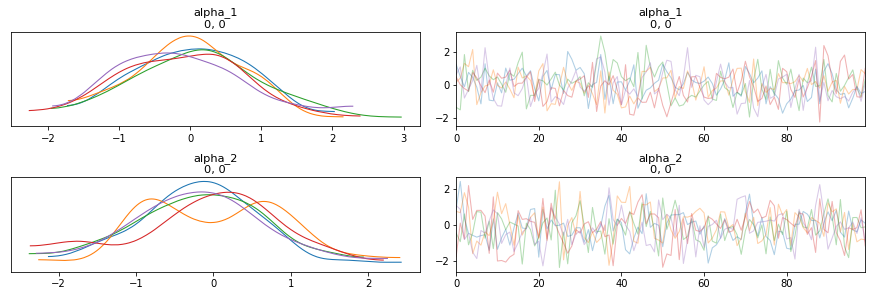

In [62]:
import arviz as az

# using the pymc3 naming convention
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}
sample_stats['tree_size'] = np.diff(sample_stats['tree_size'], axis=1)

var_name = ['alpha_1', 'alpha_2']
posterior = {k:np.swapaxes(v.numpy(), 1, 0) 
             for k, v in zip(var_name, samples[0:2])}

az_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)

az.plot_trace(az_trace)